# Применение алгоритма Q-learning на примере игры CartPole
### Обучение с подкреплением

<br>

### Теоретическое введение

**Обучение с подкреплением** &mdash; один из способов машинного обучения, в ходе которого испытуемая система (агент) обучается, взаимодействуя с некоторой средой. Откликом среды на принятые решения являются сигналы подкрепления, поэтому такое обучение является частным случаем обучения с учителем, но учителем является среда или её модель.

<img src="https://www.kdnuggets.com/images/reinforcement-learning-fig1-700.jpg">

<br>

#### Марковский процесс принятия решений (MDP)

В базовом виде обучение с подкреплением можно представить как марсковский процесс принятия решений:

$$ (S, A, P_a(s, s'), R_a(s, s')),$$

где:
1. $S$ &ndash; пространство возможных состояний среды,
2. $A$ &ndash; пространство возможных действий агента над средой,
3. $P_a(s, s') = P(s_{t+1}=s'\,|\,s_t=s,\:a_t=a)$ &ndash; вероятность, что состояние $s$ под действием $a$ во время $t$ перейдёт в состояние $s'$ ко времени $t+1$,
4. $R_a(s, s') = R(s_{t+1}=s'\,|\,s_t=s,\:a_t=a)$ &ndash; вознаграждение, получаемое после перехода в состояние $s'$ из состояния $s$ с вероятностью $P_a(s,s')$.

Вводится некоторая политика (правило, policy):

$$\pi \, : \; S \times A \rightarrow [0, 1]$$

$$\pi(a\,|\,s) = P(a_t=a\,|\,s_t=s)$$ &ndash; вероятность действия $a$ в состоянии $s$.

Не будем вдаваться в подробности марковского процесса принятия решений (value-function), а сразу рассмотрим интересующий нас случай, а именно обучение с подкреплением.

#### Обучение с подкреплением (RL)

Цель агента &ndash; выбрать такую оптимальную политику $\pi$, обозначающую вероятность выбора действия $a$ в состоянии $s$, чтобы при следовании ей сумма вознаграждений, получаемых от среды, была максимальна.

Ожидаемая награда в момент времени $t$ определяется как:

$$R_t = E[r_t \,+\, \gamma r_{t+1} \,+\, \gamma^2 r_{t+2}\, +\,\, ...] = E\left[\sum_{k=0}^{\infty}\gamma^kr_{t+k}\right],$$

где $E[\cdot]$ - математическое ожидание, $\gamma\in(0, 1)$ - discount rate.

Введем action-value функцию:

$$Q^{\pi}(s, a) = E_{\pi}[R_t|\,s_t=s, a_t=a] = E_{\pi}\left[\sum_{k=0}^{\infty}\gamma^kr_{t+k}\,|\,s_t=s, a_t=a\right],$$

где индекс $\pi$ означает выбор действий в соотвествии с некоторой политикой (policy).

Эта функция характеризует ожидаемую награду, получаемую агентом стартуя из состояния $s, s \in S$ совершая действие $a, a \in A$, и в дальнейшем действуя в соответсвии с определенной политикой $\pi$.

Отсюда мы можем получить рекурсивную формулу для оценки данной функции:

$$Q_{i+1}^{\pi}(s, a) = E_{\pi}\left[r_t + \gamma\sum_{k=0}^{\infty}\gamma^kr_{t+k+1}\,|\,s_t=s, a_t=a\right] = E_{\pi}\left[r_t + \gamma Q_{i}^{\pi}(s_{t+1}=s', a_{t+1}=a')\,|\,s_t=s, a_t=a\right]$$

Однако, цель агента &ndash; найти оптимальную политику $\pi$, на которой достигается максимальная ожидаемая награда. Таким образом, мы должны найти такую $\pi^*$, которая в результате нам дает максимальное значение action-value функции $Q^*(s, a)$ среди всех существующих политик. Формула для оценки оптимального значения action-value функции определяется следующим образом:

$$Q_{i+1}(s, a) = E[r_t + \gamma max_{a'}Q_i(s', a')\,|\,s, a]$$

При $i \rightarrow \infty$ следует, что $Q_{i}(s, a) \rightarrow Q^*(s, a)$. Это так называемый value iteration algorithm.

Грубо говоря, в этом и заключается метод **Q-learning**. Далее строят таблицу (Q-table) значений $Q(s, a)$ в различных состояних при различных действиях, и тем самым выбирают оптимальное поведение.

<img src="https://italolelis.com/images/snake-q-learning/qtable.png">

Однако, нередки случаи, когда размерность пространств $S$ или $A$ очень велика, а то и вообще бесконечна. В таком случае мы уже не в состоянии построить подобную таблицу. Для выхода из этой ситуации вводят аппроксимацию оценки функции $Q(s, a)$ с помощью некоторой параметризованной функции $Q(s, a; \theta)$. Затем используют методы оптимизации (градиентный спуск, например) для минимизации следующей loss-функции:

$$L(\theta) = E_{\pi}\left[\left(r + \gamma max_{a'}Q_{i}(s', a'; \theta) - Q_{i}(s, a; \theta)\right)^2\right]$$

В качестве аппроксимирующей функии могут выступать как линейные, так и нелинейные функции (например, нейронные сети).

<br>

### Basic Q-learning на примере CartPole

#### CartPole и OpenAI gym

Для демонстрации обучения с подкреплением попробуем обучить компьютер играть в игру CartPole. Цель игрока в CartPole &ndash; таким образом двигать тележку (cart), чтобы балансирующий на ней шест (pole) не упал. Игроку доступно всего лишь два действия &ndash; подвинуть тележку влево или вправо.

<!--<img src="http://gym.openai.com/v2018-02-21/videos/CartPole-v1-fb83b2dc-e624-485a-ad24-273c2746d3be/poster.jpg">-->
<img src="https://github.com/keon/deep-q-learning/blob/master/assets/animation.gif?raw=true">

Как говорилось ранее, в задаче обучения с подкреплением фигурируют две взаимодействующие сущности - среда и объект. Так как мы хотим сфокусироваться на обучении агента, для простоты будем использовать готовую симуляцию рассматриваемой среды. Существует очень удобная библиотека симуляции разнообразных сред на языке Python, называемая OpenAI gym. Работа с ней действительно очень проста:
```python
                                    next_state, reward, done, _ = env.step(action)
```
где:
1. ```action``` &ndash; 0 (налево) или 1 (направо), так как у нас всего лишь два действия;
2. ```next_state``` &ndash; следующее состояние (после осуществления действия action);
3. ```reward``` &ndash; награда при переходе в next_state, среда всегда возвращает единицу, покуда игра продолжается;
4. ```done``` &ndash; boolean метка, показывающая, закончилась ли игра, или еще нет.

Состояние среды описывается четыремя параметрами:
1. Координата тележки: $x\in[-4.8, 4.8]$;
2. Скорость тележки: $x'\in(-\infty, +\infty)$;
3. Угол отклонения шеста: $\theta\in[-28^{\circ}, 28^{\circ}]$;
4. Скорость отклонения шеста: $\theta'\in(-\infty, +\infty)$.

Таким образом, пространство состояний среды описывается четыремя непрерывными вещественными значениями, а пространство действий &ndash; двумя дискретными.

Игра считается проигранной, если одна из координат вышла за свои пределы. Задача считается выполненной, если агент не проигрывает в течение более 195 временных шагов 100 раз подряд.

#### Дискретизация пространства состояний

Как говорилось в теоретическом введении, политика (policy) определяет действие, которое следует совершить, находясь в текущем состоянии. В задаче обучения с подкреплением необходимо найти политику, максимизирующую награду. Q-learning как раз и является алгоритмом по нахождению подобных оптимальных политик. По сути, мы должны найти значение Q-функции (см. теорию) для каждой пары состояние-действие. Q-функция же представляет целесообразность действия с учетом текущего состояний.

Однако, в нашем случае, мы не можем найти значение Q-функции для каждой пары состояние-действие, так как число состояний в игре бесконечно. Для использования Q-learning необходимо дискретизировать непрерывные вещественные величины на некоторое число сегментов. По хорошему, число сегментов, ровно как и число состояний, должно быть как можно меньше, чтобы минимизировать время, затраченное на обучение. Но не стоит забывать, что чрезмерная дискретизация может сильно исказить полезную информацию.

Число сегментов дискретизации для каждого из параметров среды &ndash; изменяемая величина, от которой напрямую зависит качество и скорость обучения. В рамках данной задачи можно предположить, что нам вообще не нужно учитывать положение и скорость тележки, так как главная задача &ndash; удержать шест в вертикальном положении. Это достаточно наивный подход, и в нем также делается предположение о том, что вероятность проиграть вследствие выхода за границы мала на промежутке примерно в 200 временных шагов.

#### Q-функция

Алгоритм обновления значений Q-функции выглядет следующим образом:

<img src="https://res.cloudinary.com/practicaldev/image/fetch/s--k7Z0JGcN--/c_limit%2Cf_auto%2Cfl_progressive%2Cq_auto%2Cw_880/https://ferdinand-muetsch.de/images/cartpole3.png">

Новое значение Q-функции зависит от его старого значения, мгновенного вознаграждения, полученного за действие, и максимального значения Q-функции, достижимого в следующем состоянии. Таким образом, Q-функция состояния-действия косвенно зависит от всех Q-функций преемников, что и выражается в данном рекурсивном определени. В итоге, агент обладает (многомерной) таблицей, отображающей состояния и действия на Q-функцию, так, что учитывая любое состояние, лучшее действие может быть выбрано путем выбора максимального соответсвующего состоянию-действию значения Q-функции.

#### Exploration vs. Exploitation

Если кто то интересовался обучением с подкреплением, то он наверняка слышал об exploration vs. exploitation дилемме. Суть в том, что нам приходится выбирать, что важнее: exploration, то есть исследование, получение новой информации, либо exploitation, то есть эксплуатация, делать решения только на основе уже имеющейся информации. Обычно, желательно находить золотую середину между этими двумя противоположными стратегиями. Этого мы можем добиться следующим образом: агент будет выбирать случайное действие с некоторой частотой, называемой exploration rate. Таким образом, у него будет воможность обнаруживать ранее незамеченные закономерности.

#### Параметры обучения агента

Перед тем, как реализовывать агента, поговорим о некоторых его параметрах:
1. ```buckets``` &ndash; параметры дискретезации пространства состояний;
2. ```alpha``` &ndash; learning rate, грубо говоря, скорость обучения;
3. ```alpha_min``` &ndash; минимальный learning rate (в процессе уменьшается с 1 до минимального значения);
4. ```epsilon``` &ndash; exploration rate, с какой частотой агент выбирает случайное действие;
5. ```epsilon_min``` &ndash; минимальный exploration rate (в процессе уменьшается с 1 до минимального значения);
6. ```ada_divisor``` &ndash; с какого временного шага ```alpha``` и ```epsilon``` начинают уменьшаться;
7. ```gamma``` &ndash; discount factor, используется для вычисления дисконтированной будущей награды.

Рассмотрим также параметры, специфичные именно для самого процесса обучения:
1. ```n_episodes``` &ndash; число сыгранных агентом игр в процессе обучения;
2. ```n_win_ticks``` &ndash; время, которое должен продержаться агент, чтобы игра считалась выигранной;
3. ```n_win_episodes``` &ndash; число игр, которые необходимо выиграть, чтобы считать задачу решенной.

#### Реализация Basic Q-learning

#### Импорт необходимых модулей

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
import numpy as np
import math
import random
import time as tm
import matplotlib.pyplot as plt
from collections import deque

import gym

#### Класс BasicQAgent

In [3]:
class BasicQAgent:
    def __init__(self, buckets=(1, 1, 6, 12), action_size=2, alpha_min=0.1,
                 epsilon_min=0.1, ada_divisor=25, gamma=1.0):
        self.buckets = buckets
        self.action_size = action_size
        self.alpha = 1
        self.alpha_min = alpha_min
        self.epsilon = 1
        self.epsilon_min = epsilon_min
        self.ada_divisor = ada_divisor
        self.gamma = gamma

        self.Q = np.zeros(self.buckets + (action_size,))
        
    def init_env_bounds(self, env):
        self.upper_bounds = [env.observation_space.high[0], 0.5,
                             env.observation_space.high[2], math.radians(50)]
        self.lower_bounds = [env.observation_space.low[0], -0.5,
                             env.observation_space.low[2], -math.radians(50)]
        
    def discretize(self, obs, env=None):
        if (self.lower_bounds is None and self.upper_bounds is None):
            if env is not None:
                self.init_env_bounds(env)
            else:
                print("Failed - can't find env bounds")
                return None
            
        ratios = [(obs[i] + abs(self.lower_bounds[i])) / 
                  (self.upper_bounds[i] - self.lower_bounds[i]) 
                  for i in range(len(obs))]
        
        new_obs = [int(round((self.buckets[i] - 1) * ratios[i])) 
                   for i in range(len(obs))]
        new_obs = [min(self.buckets[i] - 1, max(0, new_obs[i])) 
                   for i in range(len(obs))]
        return tuple(new_obs)

    def choose_action(self, state):
        if np.random.random() <= self.epsilon:
            return np.random.randint(self.action_size)
        return np.argmax(self.Q[state])

    def update_q(self, state, action, reward, next_state):
        q_update = self.gamma*np.max(self.Q[next_state]) - self.Q[state][action]
        self.Q[state][action] += self.alpha * (reward + q_update)
 
    def update_alpha(self, t):
        self.alpha = max(self.alpha_min, 
                         min(self.alpha, 
                             1.0 - math.log10((t + 1) / self.ada_divisor)))

    def update_epsilon(self, t):
        self.epsilon = max(self.epsilon_min, 
                           min(self.epsilon, 
                               1.0 - math.log10((t + 1) / self.ada_divisor)))

#### Инициализация среды

In [4]:
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

#### Инициализация агента

In [5]:
agent = BasicQAgent(buckets=(1, 1, 6, 12),
                    alpha_min=0.1,
                    epsilon_min=0.1,
                    ada_divisor=25,
                    gamma=1)

agent.init_env_bounds(env)  # Для дискретизации

#### Параметры обучения

In [6]:
n_episodes = 1000
n_win_ticks = 195
n_win_episodes = 100

#### Основной цикл обучения

In [7]:
#scores = deque(maxlen=n_episodes)
scores = list()
win_times = 0

start = tm.time()
for episode in range(n_episodes):
    current_state = agent.discretize(env.reset(), env)
    agent.update_alpha(episode)
    agent.update_epsilon(episode)

    done = False
    time = 0

    while not done:
        action = agent.choose_action(current_state)
        obs, reward, done, _ = env.step(action)
        next_state = agent.discretize(obs, env)
        agent.update_q(current_state, action, reward, next_state)
        current_state = next_state
        time += 1

    scores.append(time)
    try:
        current_mean_score = np.mean(scores[-n_win_episodes:])
    except IndexError:
        current_mean_score = np.mean(scores)
        
    if time >= n_win_ticks:
        win_times += 1
        if win_times >= n_win_episodes:
            print('Solved at {} episode ✔'.format(episode))
            break
    else:
        win_times = 0
        
    if episode % 10 == 0:
        print('[Episode {}] - Current mean survival time: {:.3f} ticks.'
              .format(episode, current_mean_score))

if win_times < n_win_episodes:
    print('Did not solve after {} episodes 😞'.format(episode))

print("Elapsed time: {:.3f} seconds".format(tm.time() - start))

[Episode 0] - Current mean survival time: 20.000 ticks.
[Episode 10] - Current mean survival time: 19.455 ticks.
[Episode 20] - Current mean survival time: 22.238 ticks.
[Episode 30] - Current mean survival time: 23.355 ticks.
[Episode 40] - Current mean survival time: 22.659 ticks.
[Episode 50] - Current mean survival time: 23.275 ticks.
[Episode 60] - Current mean survival time: 23.115 ticks.
[Episode 70] - Current mean survival time: 23.958 ticks.
[Episode 80] - Current mean survival time: 26.247 ticks.
[Episode 90] - Current mean survival time: 31.000 ticks.
[Episode 100] - Current mean survival time: 38.770 ticks.
[Episode 110] - Current mean survival time: 41.980 ticks.
[Episode 120] - Current mean survival time: 48.220 ticks.
[Episode 130] - Current mean survival time: 53.390 ticks.
[Episode 140] - Current mean survival time: 58.140 ticks.
[Episode 150] - Current mean survival time: 68.680 ticks.
[Episode 160] - Current mean survival time: 80.120 ticks.
[Episode 170] - Current m

Опишем алгоритм:
1. **Цикл** по эпизодам (играм):
    1. Обнуляем среду, получаем случайное начальное состояние, дискретизируем.
    2. Обновляем ```alpha``` и ```epsilon```.
    3. **Цикл** пока текущая игра не закончится:
        1. Агент генерирует следующее действие (по началу случайно, см. exploration rate).
        2. Отдаем действие среде, получаем следующее состояние и награду.
        3. Дискретизируем состояние.
        4. Обновляем Q-table.
    4. **Если** агент продержался дольше ```n_win_ticks```:
        1. Прибавляется единица к счетчику побед.
        2. **Если** побед больше ```n_win_episodes```:
            1. Задача считается выполненной.
    5. **В другом случае**:
        1. Обнуляется счетчик побед.
    6. Каждые 10 эпизодов выводится сводная информация.
    
2. Если цикл закончился, а число побед меньше ```n_win_ticks```, то агенту не удалось выполнить задачу.
3. Выводится время выполнения.

Условие на выполнение можно ослабить: считать задачу выполненной, если за последние ```n_win_episodes``` значение ```time``` было **в среднем** больше, чем ```n_win_ticks```. Тогда задача будет решаться быстрее, но менее точно.

#### Анализ зависимости score от эпизода

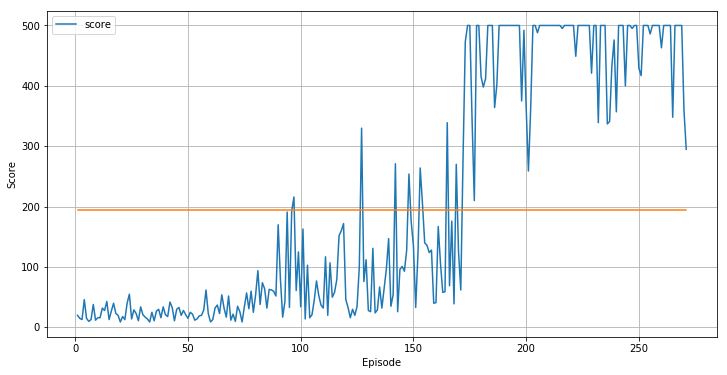

In [8]:
x_axis = np.arange(1, episode+2)
plt.figure(figsize=(12, 6))
plt.plot(x_axis, scores, label="score")
plt.plot(x_axis, [n_win_ticks for i in x_axis])
plt.xlabel("Episode")
plt.ylabel("Score")
plt.grid()
plt.legend()
plt.show()

Как видим, с подобранными выше параметрами, агент обучается примерно за 200 - 300 эпизодов. Как ни странно, получилось обучить агента не рассматривая положение и скорость тележки. Если поэксперементировать с дискретизацией, то можно добиться сходимости и с учетом координат тележки, однако это займет больше времени.

#### Пара слов о learning и exploration rate

Пару слов про характер изменения параметров ```alpha``` и ```epsilon```. В ходе обучения с течением времени эти параметры уменьшались нелинейно: 

$$\alpha = max\left(\alpha_{min},\: min\left(\alpha,\: 1 - lg\left(\frac{t-1}{ada}\right)\right)\right)$$

Аналогично для ```epsilon```. Параметр  ```ada_divisor``` определял момент времени $t$, при котором значение начинало уменьшаться, а также характер самого спуска.

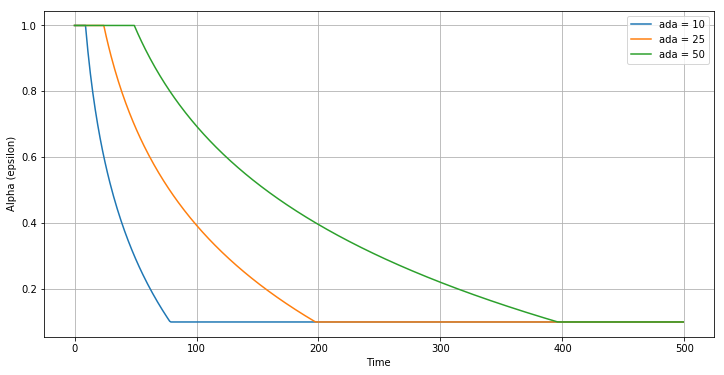

In [9]:
alpha_min = 0.1
alpha = 1
ada_divisor_1 = 10
ada_divisor_2 = 25
ada_divisor_3 = 50
x_axis = np.arange(500)

y_axis_1  = [max(alpha_min, min(alpha, 1.0 - math.log10((t + 1) / ada_divisor_1))) 
             for t in x_axis]
y_axis_2  = [max(alpha_min, min(alpha, 1.0 - math.log10((t + 1) / ada_divisor_2))) 
             for t in x_axis]
y_axis_3  = [max(alpha_min, min(alpha, 1.0 - math.log10((t + 1) / ada_divisor_3))) 
             for t in x_axis]

plt.figure(figsize=(12, 6))
plt.plot(x_axis, y_axis_1, label="ada = 10")
plt.plot(x_axis, y_axis_2, label="ada = 25")
plt.plot(x_axis, y_axis_3, label="ada = 50")
plt.xlabel("Time")
plt.ylabel("Alpha (epsilon)")
plt.grid()
plt.legend()
plt.show()

#### Вывод

Результат в действительности получился неплохим. Алгоритм работает быстро, не занимает много памяти. Однако, несмотря на такой успех, все же надо понимать, что задача слишком простая. Далеко не во всех средах реально сделать подобное снижение размерности. Поэтому необходимо рассматривать другие алгоритмы, основанные не на понижении размерности и построении Q-table, а на аппроксимации Q-функции.

<br>

### Deep-Q-Network и CartPole

В 2013 году DeepMind опубликовали свою знаменитую статью Playing Atari with Deep Reinforcement Learning, в которой представили новый алгоритм, называемый Deep Q Network (DQN). Они продемонстрировали, как искусственный обучаемый агент может играть в игры просто наблюдая за экраном монитора без получения какой либо предварительной информации об игре. Вкратце, суть DQN заключается в использовании нейронных сетей для аппроксимации Q-функции.

#### Loss функция

Перейдем к реализации DQN агента. Нам необходимо каким то образом понять, какое действие в данной момент времени принесет нам наибольшую награду в будущем. Снова посмотрим на loss функцию, которая показывает нам то, насколько наша прогнозирующая функция далека от настоящей:

<img src="https://keon.io/images/deep-q-learning/deep-q-learning.png" width="600" height="350">

Сначала мы исполняем действие $a$, переходим в состояние $s'$ и получаем награду $r$. Основываясь на результате, мы вычилсяем максимальную $Q$, а затем дисконтируем её таким образом (умножая на discount (decay) rate), чтобы моментальная награда значила больше, чем последующие (можно привести аналогию с деньгами: моментальная выплата всегда ценнее при одной и той же сумме). Затем мы добавляем текущую награду к дисконтированной будущей награде, чтобы получить целевое значение. Вычитая из целевого значение нашу аппроксимацию мы получаем ошибку (loss), которую и нужно минимизировать. 

#### Аппроксимация Q-функции

Для аппроксимации Q-функции мы будем использовать нейронную сеть, построенную с помощью библиотеки Keras.

<img src="https://keon.io/images/deep-q-learning/neuralnet.png">

Нейронная сеть будет выглядеть **примерно** как на данной схеме, но с существенным **отличием** &ndash; выходных нейронов будет два, под каждое действие. Таким образом, на вход подается состояние среды (описывается четыремя параметрами), а на выходе мы получаем **два** значения &ndash; Q-функцию для каждого действия.

Использование Keras позваляет нам не реализовывать метод градиентного спуска и находить целевое значение очень простым способом:
```python
                          target = reward + gamma * np.amax(model.predict(next_state))
```
где ```model``` &ndash; нейронная сеть.

#### Запоминание и воспроизводство

Следующей важной особенностью DQN является запоминание и воспроизводство (remember and replay). Проблемой неронной сети является то, что она имеет тенденцию забывать предыдущий опыт и перезаписывать его новыми знаниями. Для этого мы должны создать некоторый буфер памяти, запоминающий кортежи ```(state, action, reward, next_state, done)``` (это часть remember), а затем обучать нейронную сеть на некотором случайном семпле из этого буфера памяти (это replay).

#### Параметры обучения агента

В целом параметры такие же, как и в случае Basic Q-learning. Больше нет параметра ```alpha```, зато есть ```learning_rate```. Это параметр нейронной сети, он задается при её создании и используется при обучении. ```n_hidden_neurons``` &ndash; также новый параметр, отвечает за число нейронов в скрытом слое сети.

### Реализация DQN

#### Импорт необходимых модулей

In [10]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras import backend as K
import tensorflow as tf

Using TensorFlow backend.


#### Класс DQNAgent

In [11]:
class DQNAgent:
    def __init__(self, state_size=4, action_size=2,
                 epsilon_min=0.1, ada_divisor=25, gamma=0.95,
                 learning_rate=0.001, n_hidden_neurons=24):
        self.state_size = state_size
        self.action_size = action_size

        self.epsilon = 1.0
        self.epsilon_min = epsilon_min
        self.ada_divisor = ada_divisor
        self.gamma = gamma
        
        self.learning_rate = learning_rate
        self.n_hidden_neurons = n_hidden_neurons
        
        self.memory = deque(maxlen=2000)
        self.model = self._build_model()
        
    def _build_model(self):
        # Neural Network for Deep-Q learning Model
        # The Sequential model is a linear stack of layers
        model = Sequential()
        
        # Dense is regular densely-connected NN layer
        # Input layer with state_size input parameters and 24 neurons
        # in the first hidden layer
        model.add(Dense(self.n_hidden_neurons, 
                        input_dim=self.state_size, activation='relu'))
        
        # Second hidden layer 2 with 24 neurons
        model.add(Dense(self.n_hidden_neurons, activation='relu'))
        
        # Output layer with action_size neurons
        model.add(Dense(self.action_size, activation='linear'))
        
        # Compile model
        # Adam optimizer is modified GD
        model.compile(loss="mse",
                      optimizer=Adam(lr=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return 0
        
        loss = []
        batch = random.sample(self.memory, batch_size)
        
        for state, action, reward, next_state, done in batch:
            q_values = self.model.predict(state)
            if done:
                q_values[0][action] = reward
            else:
                q_update = self.model.predict(next_state)[0]
                q_values[0][action] = reward + self.gamma * np.amax(q_update)   
            
            history = self.model.fit(state, q_values, verbose=0)
            loss.append(history.history['loss'][0])
            
        return np.mean(loss)
    
    def replay_batch(self, batch_size):
        if len(self.memory) < batch_size:
            return 0
        
        states, qs = [], []
        batch = random.sample(self.memory, batch_size)
        
        for state, action, reward, next_state, done in batch:
            q_values = self.model.predict(state)
            if done:
                q_values[0][action] = reward
            else:
                q_update = self.model.predict(next_state)[0]
                q_values[0][action] = reward + self.gamma * np.amax(q_update) 
                
            states.append(state[0])
            qs.append(q_values[0])
            
        history = self.model.fit(np.array(states), np.array(qs), verbose=0)
        loss = history.history['loss'][0]
            
        return loss

    def update_epsilon(self, t):
        self.epsilon = max(self.epsilon_min, 
                           min(self.epsilon, 
                               1.0 - math.log10((t + 1) / self.ada_divisor)))
        #self.epsilon *= 0.995

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

Описание класса DQNAgent:
1. В инициализаторе происходит определение параметров;
2. ```_build_model``` &ndash; создание нейронной сети;
3. ```remember``` &ndash; функция добавляет состояние в буфер памяти (см. выше);
4. ```act``` &ndash; агент выбирает следующее действие;
5. ```replay``` &ndash; нейронная сеть обучается на случайном семпле из памяти;
6. ```replay_batch``` &ndash; более быстрый аналог функции ```replay```, обучается не на каждой паре state-Q отдельно, а сразу на всех из семпла;
6. ```load``` и ```save``` &ndash; загрузка и сохранение нейронной сети.

Рассмотрим алгоритм функции ```replay``` подробнее:
1. **Если** в памяти записей меньше, чем ```batch_size```:
    1. Выйти из функции.
2. Получение случайного семпла ```(state, action, reward, next_state, done)``` из памяти.
3. **Цикл** по случайному семплу:
    1. Вызываем метод ```model.predict(state)```, то есть даем нейроести на вход начальное состояние, получаем список из двух значений Q-функции для обоих действий. Записываем в ```q_values```.
    2. **Если** данный момент из памяти является завершающим игру, то:
        1. Меняем значение ```q_values``` для действия, переводящего ```state``` в ```next_state```, наградой, полученной при этом переходе.
    3. **В другом случае:**
        1. Меняем значение ```q_values``` для действия, переводящего ```state``` в ```next_state```, наградой, полученной при этом переходе, с прибавленной к ней дисконтированной максимизированной Q-функции для ```next_state``` (см. формулы).
    4. Нейронная сеть обучается, на вход подается ```state```, на выход &ndash; обновленный ```q_values```. Записывается training loss.
4. Из функции возвращается средний training loss.

#### Инициализация среды

In [12]:
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

#### Инициализация агента

In [13]:
agent = DQNAgent(state_size, action_size,
                 epsilon_min=0.1,
                 ada_divisor=20,
                 gamma=0.95,
                 learning_rate=0.001,
                 n_hidden_neurons=24)

#### Параметры обучения

In [14]:
n_episodes = 1000
n_win_ticks = 195
n_win_episodes = 100
batch_size = 20

#### Основной цикл обучения

In [15]:
scores, mean_scores, loss_history = [], [], []

start = tm.time()
for episode in range(n_episodes):
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    agent.update_epsilon(episode)
    
    done = False
    time = 0
    loss_episode = []
    
    while not done:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        reward = reward if not done else -reward
        next_state = np.reshape(next_state, [1, state_size])
        agent.remember(state, action, reward, next_state, done)
        
        loss = agent.replay_batch(batch_size)
        loss_episode.append(loss)
        state = next_state
        time += 1
        
    scores.append(time)
    loss_history.append(np.mean(loss_episode))
    try:
        current_mean_score = np.mean(scores[-n_win_episodes:])
    except IndexError:
        current_mean_score = np.mean(scores)
        
    mean_scores.append(current_mean_score)
    if current_mean_score >= n_win_ticks:
        win_times += 1
        if win_times >= n_win_episodes:
            print('Solved at {} episode ✔'.format(episode))
            break
    else:
        win_times = 0
        
    if episode % 10 == 0:
        print('[Episode {}] - Current mean survival time : {:.3f} ticks, loss: {:.3f}.'
              .format(episode, current_mean_score, loss_history[-1]))
        
if win_times < n_win_episodes:
    print('Did not solve after {} episodes 😞'.format(episode))
    
print("Elapsed time: {:.3f} seconds".format(tm.time() - start))

[Episode 0] - Current mean survival time : 39.000 ticks, loss: 0.286.
[Episode 10] - Current mean survival time : 27.000 ticks, loss: 14.314.
[Episode 20] - Current mean survival time : 28.810 ticks, loss: 5.298.
[Episode 30] - Current mean survival time : 26.097 ticks, loss: 9.600.
[Episode 40] - Current mean survival time : 25.195 ticks, loss: 4.158.
[Episode 50] - Current mean survival time : 32.039 ticks, loss: 2.996.
[Episode 60] - Current mean survival time : 41.820 ticks, loss: 2.143.
[Episode 70] - Current mean survival time : 50.113 ticks, loss: 1.473.
[Episode 80] - Current mean survival time : 59.704 ticks, loss: 0.777.
[Episode 90] - Current mean survival time : 73.615 ticks, loss: 0.346.
[Episode 100] - Current mean survival time : 85.980 ticks, loss: 0.240.
[Episode 110] - Current mean survival time : 100.320 ticks, loss: 0.201.
[Episode 120] - Current mean survival time : 107.460 ticks, loss: 0.598.
[Episode 130] - Current mean survival time : 121.920 ticks, loss: 0.335.

Опишем алгоритм:
1. **Цикл** по эпизодам (играм):
    1. Обнуляем среду, получаем случайное начальное состояние, преобразуем массив (reshape для работы НС).
    2. Обновляем ```epsilon```.
    3. **Цикл** пока текущая игра не закончится:
        1. Агент генерирует следующее действие (по началу случайно, см. exploration rate).
        2. Отдаем действие среде, получаем следующее состояние и награду.
        3. Меняем знак награды, если игра закончилась.
        4. Запоминаем ```(state, action, reward, next_state, done)```.
        5. Вызываем метод ```replay```, который обучает нейронную сеть.
        6. Записываем training loss.
    3. Считаем средний score за последние ```n_win_episodes``` эпизодов.
    4. **Если** средний score больше ```n_win_ticks```:
        1. Прибавляется единица к счетчику побед.
        2. **Если** побед больше ```n_win_episodes```:
            1. Задача считается выполненной.
    5. **В другом случае**:
        1. Обнуляется счетчик побед.
    6. Каждые 10 эпизодов выводится сводная информация.
    
2. Если цикл закончился, а число побед меньше ```n_win_ticks```, то агенту не удалось выполнить задачу.
3. Выводится время выполнения.

Также можно добавить функционал сохранения модели в течение обучения, так как оно происходит не быстро.

Как можно заметить, условие на выполнение было ослабленно. Так как мы серьезно усложнили агента, добавив нейронную сеть, время на обучение существенно увеличилось. Поэтому можно немного пожертвовать качеством в пользу более быстрого обучения.

#### Анализ зависимости score и loss от эпизода

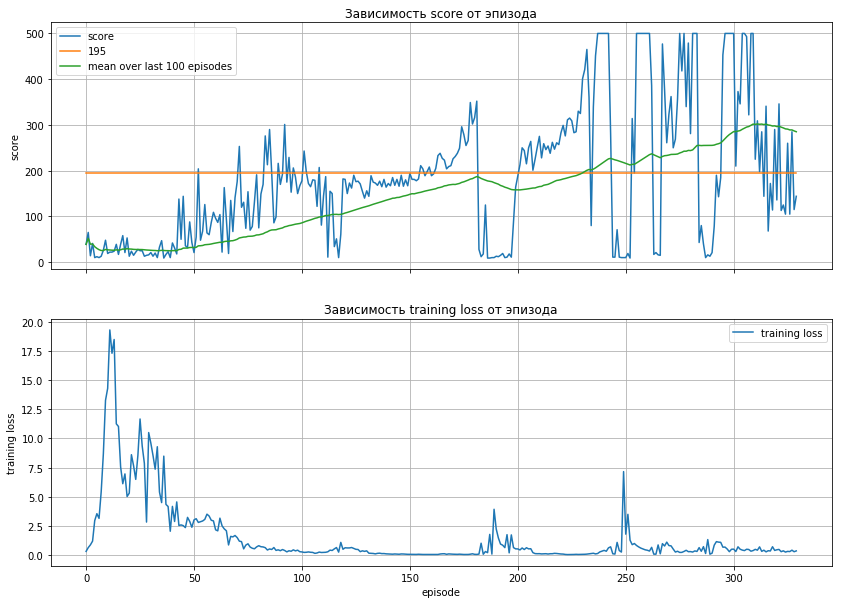

In [16]:
x_axis = np.arange(episode+1)
fig, axes = plt.subplots(2, 1, sharex='col', figsize=(14, 10))
axes[0].plot(x_axis, scores, label='score')
axes[0].plot(x_axis, [n_win_ticks for i in x_axis], label="{}".format(n_win_ticks))
axes[0].plot(x_axis, mean_scores, label='mean over last {} episodes'
                                        .format(n_win_episodes))
axes[1].plot(x_axis, loss_history, label='training loss')

for i in range(2):
    axes[i].legend()
    axes[i].grid()

axes[0].set_title("Зависимость score от эпизода")
axes[1].set_title("Зависимость training loss от эпизода")
axes[0].set_ylabel("score")
axes[1].set_ylabel("training loss")
axes[1].set_xlabel("episode")

plt.show()

Выполнить задачу с ослабленным условием удалось, но качество хуже, чем у Basic Q-learning (агент часто проигрывает), да и затраченное время заметно выше. При всем этом, каждый раз обучение происходит то быстрее, то дольше, а может агент и не обучится вообще. Возможно, это связано с неидеальным подбором параметров и недостатками именно этой реализации.

<br>

### Примечание

**Автор: Болгарин Максим. Физический факультет, МГУ, 2018г.**

Теоретическое введение было написано при использовании статей на [википедии](https://en.wikipedia.org/wiki/Reinforcement_learning), а также статьи Deep Reinforcement Learning: An Overview, авторами которой являются Seyed Sajad Mousavia, Michael Schukata, Enda Howleya.

Материал и код, используемый при реализации Basic Q-learning был взят [отсюда](https://dev.to/n1try/cartpole-with-q-learning---first-experiences-with-openai-gym), при реализации DQN [отсюда](https://keon.io/deep-q-learning/). Код подвергался изменениям.

Я не занимался копированием и переводом, а лишь своими словами описывал то, что узнал в этих источниках.